In [13]:
import numpy as np
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [14]:
df = pd.read_csv('dataset/goog-train.csv')
df.shape

(755, 6)

In [15]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1

In [16]:
class neuralnetwork:
    def __init__(self, id_, hidden_size = 128):
        self.W1 = np.random.randn(window_size, hidden_size) / np.sqrt(window_size)
        self.W2 = np.random.randn(hidden_size, 3) / np.sqrt(hidden_size)
        self.fitness = 0
        self.id = id_

def relu(X):
    return np.maximum(X, 0)
    
def softmax(X):
    e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def feed_forward(X, nets):
    a1 = np.dot(X, nets.W1)
    z1 = relu(a1)
    a2 = np.dot(z1, nets.W2)
    return softmax(a2)

In [17]:
class NeuroEvolution:
    def __init__(self, population_size, mutation_rate, model_generator,
                state_size, window_size, trend, skip, initial_money):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.model_generator = model_generator
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        
    def _initialize_population(self):
        self.population = []
        for i in range(self.population_size):
            self.population.append(self.model_generator(i))
    
    def mutate(self, individual, scale=1.0):
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W1.shape)
        individual.W1 += np.random.normal(loc=0, scale=scale, size=individual.W1.shape) * mutation_mask
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W2.shape)
        individual.W2 += np.random.normal(loc=0, scale=scale, size=individual.W2.shape) * mutation_mask
        return individual
    
    def inherit_weights(self, parent, child):
        child.W1 = parent.W1.copy()
        child.W2 = parent.W2.copy()
        return child
    
    def crossover(self, parent1, parent2):
        child1 = self.model_generator((parent1.id+1)*10)
        child1 = self.inherit_weights(parent1, child1)
        child2 = self.model_generator((parent2.id+1)*10)
        child2 = self.inherit_weights(parent2, child2)
        # first W
        n_neurons = child1.W1.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W1[:, cutoff:] = parent2.W1[:, cutoff:].copy()
        child2.W1[:, cutoff:] = parent1.W1[:, cutoff:].copy()
        # second W
        n_neurons = child1.W2.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W2[:, cutoff:] = parent2.W2[:, cutoff:].copy()
        child2.W2[:, cutoff:] = parent1.W2[:, cutoff:].copy()
        return child1, child2
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def act(self, p, state):
        logits = feed_forward(state, p)
        return np.argmax(logits, 1)[0]
    
    def buy(self, individual, trends):
        initial_money = self.initial_money
        starting_money = initial_money
        state = self.get_state(0)
        inventory = []
        states_sell = []
        states_buy = []
        
        for t in range(0, len(trends) - 1, self.skip):
            action = self.act(individual, state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= trends[t]:
                inventory.append(trends[t])
                initial_money -= trends[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, trends[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += trends[t]
                states_sell.append(t)
                try:
                    invest = ((trends[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, trends[t], invest, initial_money)
                )
            state = next_state
        
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def calculate_fitness(self):
        for i in range(self.population_size):
            initial_money = self.initial_money
            starting_money = initial_money
            state = self.get_state(0)
            inventory = []
            
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(self.population[i], state)
                next_state = self.get_state(t + 1)
            
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    starting_money += self.trend[t]

                state = next_state
            invest = ((starting_money - initial_money) / initial_money) * 100
            self.population[i].fitness = invest
        
    
    def evolve(self, generations=20, checkpoint= 5):
        self._initialize_population()
        n_winners = int(self.population_size * 0.4)
        n_parents = self.population_size - n_winners
        for epoch in range(generations):
            self.calculate_fitness()
            fitnesses = [i.fitness for i in self.population]
            sort_fitness = np.argsort(fitnesses)[::-1]
            self.population = [self.population[i] for i in sort_fitness]
            fittest_individual = self.population[0]
            if (epoch+1) % checkpoint == 0:
                print('epoch %d, fittest individual %d with accuracy %f'%(epoch+1, sort_fitness[0], 
                                                                          fittest_individual.fitness))
            next_population = [self.population[i] for i in range(n_winners)]
            total_fitness = np.sum([np.abs(i.fitness) for i in self.population])
            parent_probabilities = [np.abs(i.fitness / total_fitness) for i in self.population]
            parents = np.random.choice(self.population, size=n_parents, p=parent_probabilities, replace=False)
            for i in np.arange(0, len(parents), 2):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                next_population += [self.mutate(child1), self.mutate(child2)]
            self.population = next_population
        return fittest_individual

In [18]:
population_size = 100
generations = 100
mutation_rate = 0.1
neural_evolve = NeuroEvolution(population_size, mutation_rate, neuralnetwork,
                              window_size, window_size, close, skip, initial_money)

In [19]:
fittest_nets = neural_evolve.evolve(50)

epoch 5, fittest individual 0 with accuracy 37.604127
epoch 10, fittest individual 0 with accuracy 74.635608
epoch 15, fittest individual 0 with accuracy 74.635608
epoch 20, fittest individual 0 with accuracy 74.635608
epoch 25, fittest individual 0 with accuracy 74.635608
epoch 30, fittest individual 0 with accuracy 77.163323
epoch 35, fittest individual 0 with accuracy 77.163323
epoch 40, fittest individual 0 with accuracy 77.163323
epoch 45, fittest individual 0 with accuracy 77.163323
epoch 50, fittest individual 0 with accuracy 77.163323


In [20]:
states_buy, states_sell, total_gains, invest = neural_evolve.buy(fittest_nets,close)

day 1: buy 1 unit at price 512.463013, total balance 9487.536987
day 2: buy 1 unit at price 500.585632, total balance 8986.951355
day 3, sell 1 unit at price 499.727997, investment -2.485060 %, total balance 9486.679352,
day 4: buy 1 unit at price 501.303680, total balance 8985.375671
day 5: buy 1 unit at price 494.811493, total balance 8490.564178
day 6: buy 1 unit at price 491.201416, total balance 7999.362762
day 7: buy 1 unit at price 494.821472, total balance 7504.541290
day 8, sell 1 unit at price 499.498627, investment -0.217147 %, total balance 8004.039917,
day 9: buy 1 unit at price 500.416107, total balance 7503.623810
day 12, sell 1 unit at price 516.621643, investment 3.055625 %, total balance 8020.245453,
day 15, sell 1 unit at price 533.744629, investment 7.868276 %, total balance 8553.990082,
day 16: buy 1 unit at price 517.210022, total balance 8036.780060
day 17: buy 1 unit at price 508.603638, total balance 7528.176422
day 18: buy 1 unit at price 509.261810, total bal

day 373, sell 1 unit at price 668.260010, investment -6.731424 %, total balance 4111.296997,
day 375: buy 1 unit at price 684.109985, total balance 3427.187012
day 376, sell 1 unit at price 692.099976, investment -2.056243 %, total balance 4119.286987,
day 377, sell 1 unit at price 699.210022, investment -0.158497 %, total balance 4818.497009,
day 379, sell 1 unit at price 697.770020, investment -0.918717 %, total balance 5516.267029,
day 380: buy 1 unit at price 695.359985, total balance 4820.907043
day 381: buy 1 unit at price 705.630005, total balance 4115.277039
day 382, sell 1 unit at price 715.090027, investment -2.804048 %, total balance 4830.367065,
day 384: buy 1 unit at price 716.979980, total balance 4113.387085
day 386: buy 1 unit at price 719.849976, total balance 3393.537109
day 390, sell 1 unit at price 738.630005, investment 1.126777 %, total balance 4132.167114,
day 391: buy 1 unit at price 742.739990, total balance 3389.427124
day 392: buy 1 unit at price 739.770020, 

day 564: buy 1 unit at price 831.500000, total balance 4719.812439
day 566, sell 1 unit at price 838.549988, investment 4.515652 %, total balance 5558.362427,
day 568, sell 1 unit at price 831.409973, investment 4.344934 %, total balance 6389.772400,
day 569: buy 1 unit at price 827.880005, total balance 5561.892395
day 570, sell 1 unit at price 824.669983, investment 3.641468 %, total balance 6386.562378,
day 571: buy 1 unit at price 824.729980, total balance 5561.832397
day 572, sell 1 unit at price 823.349976, investment 2.727418 %, total balance 6385.182373,
day 573: buy 1 unit at price 824.320007, total balance 5560.862366
day 574: buy 1 unit at price 823.559998, total balance 4737.302368
day 575: buy 1 unit at price 837.169983, total balance 3900.132385
day 576, sell 1 unit at price 836.820007, investment 4.427581 %, total balance 4736.952393,
day 578, sell 1 unit at price 841.650024, investment 4.297564 %, total balance 5578.602417,
day 583, sell 1 unit at price 874.250000, inve

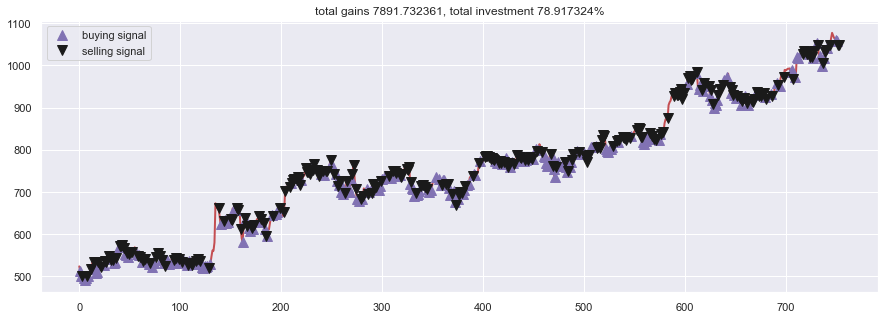

In [21]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [22]:
df = pd.read_csv('dataset/goog-test.csv')
close2 = df.Close.values.tolist()


In [23]:
states_buy, states_sell, total_gains, invest = neural_evolve.buy(fittest_nets,close2)

day 1: buy 1 unit at price 1082.479980, total balance 8917.520020
day 2: buy 1 unit at price 1086.400024, total balance 7831.119995
day 3, sell 1 unit at price 1102.229980, investment 1.824514 %, total balance 8933.349976,
day 4: buy 1 unit at price 1106.939941, total balance 7826.410034
day 5: buy 1 unit at price 1106.260010, total balance 6720.150024
day 6: buy 1 unit at price 1102.609985, total balance 5617.540039
day 7: buy 1 unit at price 1105.520020, total balance 4512.020020
day 8, sell 1 unit at price 1122.260010, investment 3.300809 %, total balance 5634.280029,
day 9: buy 1 unit at price 1121.760010, total balance 4512.520020
day 12, sell 1 unit at price 1137.510010, investment 2.761674 %, total balance 5650.030029,
day 15, sell 1 unit at price 1164.239990, investment 5.241081 %, total balance 6814.270020,
day 16: buy 1 unit at price 1170.369995, total balance 5643.900024
day 17: buy 1 unit at price 1175.839966, total balance 4468.060059
day 18: buy 1 unit at price 1175.57995

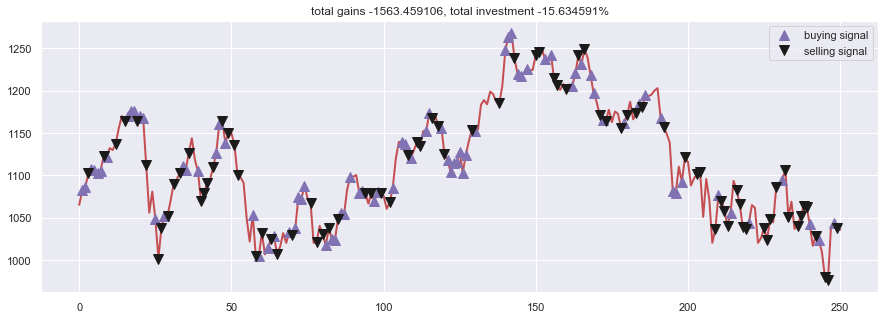

In [24]:
fig = plt.figure(figsize = (15,5))
plt.plot(close2, color='r', lw=2.)
plt.plot(close2, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close2, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()